In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from os.path import join as pjoin
from scipy.io import mmread
import scanpy as sc
import anndata
import squidpy as sq
from gpsa import VariationalGPSA, rbf_kernel
import torch
from IPython.display import display, clear_output
import os
# import sys
# sys.path.append("../../../../paste")
# from src.paste import PASTE, visualization
# import scanpy as sc


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
def rotate_90deg_counterclockwise(coords):
    y_coords_reflected = -coords[:, 1] - coords[:, 1].max()
    return np.vstack([y_coords_reflected, coords[:, 0]]).T

In [5]:
DATA_DIR = "../../../data/mouse_brain_slideseq/12_allMTXs_CCF/"

## Load data

In [6]:
fnames = os.listdir(DATA_DIR)
barcode_files = [f for f in fnames if "barcodes" in f]
slice_nums = np.sort([int(f.split("_")[1][1:]) for f in barcode_files])

In [7]:
n_slices = 2

gene_list = pd.read_table(pjoin(DATA_DIR, "01_Gene_List.txt"), header=None).values.squeeze()
metadata_list = []
data_list = []

for snum in slice_nums[:n_slices]:
    curr_metadata = pd.read_table(pjoin(DATA_DIR, "MBASS_d{}_metadata.tsv".format(snum)))
    metadata_list.append(curr_metadata)
    del curr_metadata
    
    curr_barcodes = pd.read_table(pjoin(DATA_DIR, "MBASS_d{}_barcodes.txt".format(snum)), header=None).values.squeeze()
    
    curr_data_sparse = mmread(pjoin(DATA_DIR, "MBASS_d{}_matrix.mtx".format(snum)))
    curr_data = pd.DataFrame(curr_data_sparse.toarray(), index=gene_list, columns=curr_barcodes)
    data_list.append(curr_data)
    
    del curr_barcodes
    del curr_data_sparse
    del curr_data


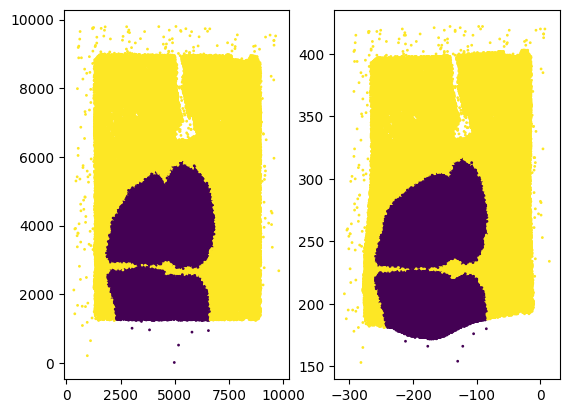

In [8]:

plt.subplot(121)
plt.scatter(metadata_list[0].Original_x, metadata_list[0].Original_y, c=metadata_list[0].isOutsideCCF, s=1)

plt.subplot(122)
plt.scatter(-metadata_list[0].CCF3D_y, metadata_list[0].CCF3D_z, c=metadata_list[0].isOutsideCCF, s=1)
plt.show()

## Manually rotate one slice so they have same orientation

In [9]:
n_rotations_list = [3, 0]

Xs_list = []

for ss in range(n_slices):
    rotated_coords = metadata_list[ss][["Original_x", "Original_y"]].values.copy()
    for nr in range(n_rotations_list[ss]):
        rotated_coords = rotate_90deg_counterclockwise(rotated_coords)
        
    Xs_list.append(rotated_coords)

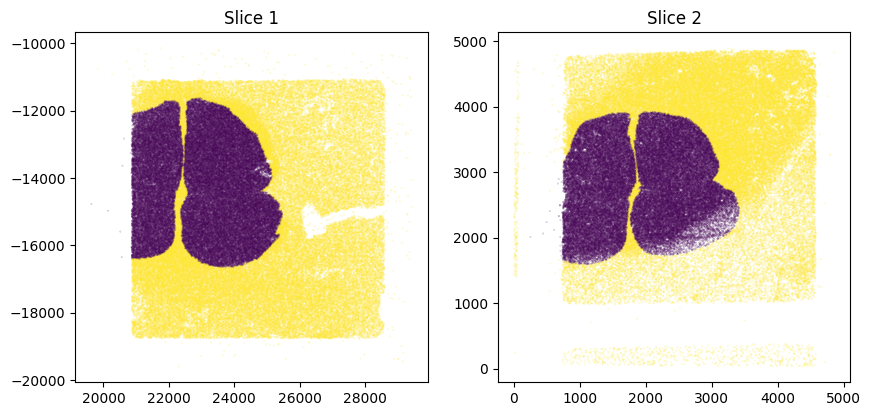

In [10]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(Xs_list[0][:, 0], Xs_list[0][:, 1], s=.01, c=metadata_list[0].isOutsideCCF.values)
plt.title("Slice 1")
# plt.axis("off")

plt.subplot(222)
plt.scatter(Xs_list[1][:, 0], Xs_list[1][:, 1], s=.01, c=metadata_list[1].isOutsideCCF.values)
plt.title("Slice 2")
# plt.axis("off")

# plt.subplot(223)
# X_slice1_ccf = metadata_slice1[["CCF3D_z", "CCF3D_y"]].values
# X_slice1_ccf = X_slice1_ccf[~metadata_slice1.isOutsideCCF]
# plt.scatter(X_slice1_ccf[:, 0], X_slice1_ccf[:, 1], s=.01)
# plt.title("Slice 1, CCF coordinates")
# # plt.axis("off")

# plt.subplot(224)
# X_slice2_ccf = metadata_slice2[["CCF3D_z", "CCF3D_y"]].values
# X_slice2_ccf = X_slice2_ccf[~metadata_slice2.isOutsideCCF]
# plt.scatter(X_slice2_ccf[:, 0], X_slice2_ccf[:, 1], s=.01)
# plt.scatter(X_slice1_ccf[:, 0], X_slice1_ccf[:, 1], s=.01)
# plt.title("Slice 2, CCF coordinates")
# # plt.axis("off")
plt.show()

## Filter for spots inside the tissue and create AnnData objects

In [11]:
n_spots = 5_000
n_genes = 10_000

anndata_list = []

for ss in range(n_slices):
    in_slice_idx = np.where(~metadata_list[ss].isOutsideCCF.values)[0]
    in_slice_idx = np.random.choice(in_slice_idx, size=n_spots, replace=False)

    X_slice = Xs_list[ss][in_slice_idx]
    Y_slice = data_list[ss].transpose().iloc[in_slice_idx, :n_genes]
    Y_slice = Y_slice.loc[:, Y_slice.sum(0) > 0]
    anndata_slice = anndata.AnnData(Y_slice)
    anndata_slice.obsm['spatial'] = X_slice
    
    anndata_list.append(anndata_slice)

<ipython-input-11-f3b44d2a3299>:13: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata_slice = anndata.AnnData(Y_slice)


## Compute spatial autocorrelation (Moran's I) for each gene

In [12]:
gene_names_sorted_list = []
for ss in range(n_slices):

    sq.gr.spatial_neighbors(anndata_list[ss])
    sq.gr.spatial_autocorr(
        anndata_list[ss],
        mode="moran",
    )
    moran_genenames_sorted = anndata_list[ss].uns["moranI"].index.values
    gene_names_sorted_list.append(gene_names_sorted_list)


In [ ]:
genenames_to_keep = gene_names_sorted_list[0][:30].copy()
for ss in range(1, n_slices):
    genenames_to_keep = np.intersect1d(genenames_to_keep, gene_names_sorted_list[ss][:30])
    
for ss in range(n_slices):
    anndata_list[ss] = anndata_list[ss][:, genenames_to_keep]

## Start alignment

In [ ]:
def scale_spatial_coords(X, max_val=10.0):
    X = X - X.min(0)
    X = X / X.max(0)
    return X * max_val

In [ ]:
n_views = 2
anndata_all_slices = anndata_slice1.concatenate(anndata_slice2)
n_samples_list = [anndata_all_slices[anndata_all_slices.obs.batch == str(ii)].shape[0] for ii in range(n_views)]

X1 = np.array(anndata_all_slices[anndata_all_slices.obs.batch == "0"].obsm["spatial"])
X2 = np.array(anndata_all_slices[anndata_all_slices.obs.batch == "1"].obsm["spatial"])
Y1 = np.log(np.array(anndata_all_slices[anndata_all_slices.obs.batch == "0"].X) + 1)
Y2 = np.log(np.array(anndata_all_slices[anndata_all_slices.obs.batch == "1"].X) + 1)

Y1 = (Y1 - Y1.mean(0)) / Y1.std(0)
Y2 = (Y2 - Y2.mean(0)) / Y2.std(0)

X1 = scale_spatial_coords(X1)
X2 = scale_spatial_coords(X2)
X = np.concatenate([X1, X2])
Y = np.concatenate([Y1, Y2])

view_idx = [
    np.arange(X1.shape[0]),
    np.arange(X1.shape[0], X1.shape[0] + X2.shape[0]),
]

x = torch.from_numpy(X).float().clone()
y = torch.from_numpy(Y).float().clone()


data_dict = {
    "expression": {
        "spatial_coords": x,
        "outputs": y,
        "n_samples_list": n_samples_list,
    }
}

In [ ]:
n_spatial_dims = 2
m_X_per_view = 100
m_G = 100
N_LATENT_GPS = {"expression": None}
N_EPOCHS = 100
PRINT_EVERY = 50

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VariationalGPSA(
    data_dict,
    n_spatial_dims=n_spatial_dims,
    m_X_per_view=m_X_per_view,
    m_G=m_G,
    data_init=True,
    minmax_init=False,
    grid_init=False,
    n_latent_gps=N_LATENT_GPS,
    mean_function="identity_fixed",
    kernel_func_warp=rbf_kernel,
    kernel_func_data=rbf_kernel,
    fixed_warp_kernel_variances=np.ones(n_views) * 1e-2,
    # fixed_warp_kernel_lengthscales=np.ones(n_views) * 10,
    fixed_view_idx=0,
).to(device)

view_idx, Ns, _, _ = model.create_view_idx_dict(data_dict)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

def train(model, loss_fn, optimizer):
    model.train()

    # Forward pass
    G_means, G_samples, F_latent_samples, F_samples = model.forward(
        X_spatial={"expression": x}, view_idx=view_idx, Ns=Ns, S=5
    )

    # Compute loss
    loss = loss_fn(data_dict, F_samples)

    # Compute gradients and take optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), G_means

In [ ]:
# Set up figure.
fig = plt.figure(figsize=(10, 5), facecolor="white", constrained_layout=True)
ax1 = fig.add_subplot(121, frameon=False)
ax2 = fig.add_subplot(122, frameon=False)
ax1.invert_yaxis()
ax2.invert_yaxis()
# plt.show(block=False)
loss_trace = []

for t in range(N_EPOCHS):
    loss, G_means = train(model, model.loss_fn, optimizer)
    loss_trace.append(loss)

    if t % PRINT_EVERY == 0 or t == N_EPOCHS - 1:
        print("Iter: {0:<10} LL {1:1.3e}".format(t, -loss))

        aligned_coords = G_means["expression"].detach().numpy()
        aligned_coords_slice1 = aligned_coords[view_idx["expression"][0]]
        aligned_coords_slice2 = aligned_coords[view_idx["expression"][1]]
        
        ax1.cla()
        ax2.cla()
        
        ax1.scatter(X1[:, 0], X1[:, 1], alpha=0.3)
        ax1.scatter(X2[:, 0], X2[:, 1], alpha=0.3)

        ax2.scatter(X1[:, 0], X1[:, 1], alpha=0.3)
        ax2.scatter(
            aligned_coords_slice2[:, 0],
            aligned_coords_slice2[:, 1],
            alpha=0.3,
        )

#         ax1.invert_yaxis()
#         ax2.invert_yaxis()

#         plt.draw()
        display(fig)
    
        clear_output(wait = True)
        plt.pause(1 / 60.0)
plt.close()

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(X1[:, 0], X1[:, 1], c=Y1[:, 0], s=5)
plt.title("Slice 1")
# plt.axis("off")

plt.subplot(222)
plt.scatter(X2[:, 0], X2[:, 1], c=Y2[:, 0], s=5)
plt.title("Slice 1")
# plt.axis("off")

plt.subplot(223)
plt.scatter(aligned_coords_slice1[:, 0], aligned_coords_slice1[:, 1], c=Y1[:, 0], s=5)
plt.title("Slice 1")
# plt.axis("off")

plt.subplot(224)
plt.scatter(aligned_coords_slice2[:, 0], aligned_coords_slice2[:, 1], c=Y2[:, 0], s=5)
plt.title("Slice 1")
# plt.axis("off")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X1[:, 0], X1[:, 1], s=5)
plt.scatter(X2[:, 0], X2[:, 1], s=5)
plt.title("Original")

plt.subplot(122)
plt.scatter(aligned_coords_slice1[:, 0], aligned_coords_slice1[:, 1], s=5)
plt.scatter(aligned_coords_slice2[:, 0], aligned_coords_slice2[:, 1], s=5)
plt.title("Aligned")
plt.show()






In [ ]:
X2 - aligned_coords_slice2




In [ ]:
X1 - aligned_coords_slice1

In [ ]:
plt.plot(loss_trace)
plt.show()
